## Non-parametric models: KNN and desision tree

### Data Preprocessing

In [1]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('data/wine_modified.csv')
print(df.shape)
df.info()

(178, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
class                   168 non-null float64
Alcohol                 178 non-null float64
Malic acid              166 non-null float64
Ash                     66 non-null float64
Alcalinity of ash       166 non-null float64
Magnesium               156 non-null float64
Total phenols           178 non-null float64
Flavanoids              130 non-null float64
Nonflavanoid phenols    164 non-null float64
Proanthocyanins         166 non-null float64
Color intensity         166 non-null float64
Hue                     164 non-null float64
OD280/OD315             167 non-null float64
Proline                 164 non-null float64
dtypes: float64(14)
memory usage: 19.5 KB


**Question 1**: Remove the rows with missing labels ('class') and rows with more than 7 missing features. Report the remaining number of rows.

In [2]:
#data = df[np.isfinite(df['class'])]
data = df[df['class'].isnull() == False]
data = data.dropna(thresh=7)
print("Data has remaining number of rows: {}".format(len(data)))

Data has remaining number of rows: 154


**Question 2**: Remove features with > 50% of missing values. For other features with missing values fill them with the mean of the corresponding features. Report the removed features (if any) and standard deviation of features with missing values after filling.

In [3]:
processed_data = data.dropna(axis=1, thresh=len(data)/2).copy()
if processed_data.shape != data.shape:
    removed_columns = set(data.columns) - set(processed_data.columns)
    print("removed features: {}".format(' '.join(removed_columns)))

incomplete_columns = processed_data.columns[processed_data.isnull().any()]
for col in incomplete_columns:
    mean = processed_data[col].mean()
    processed_data[col].fillna(mean, inplace=True)
    print("column {} std: {}".format(col, processed_data[col].std()))

removed features: Ash
column Magnesium std: 14.440377368166187
column Flavanoids std: 0.8735732194355235


**Question 3**: Detect and remove rows with any outliers/incorrect values in features 'alcohol' and 'proline' (if any). Clearly state the basis of your removal.

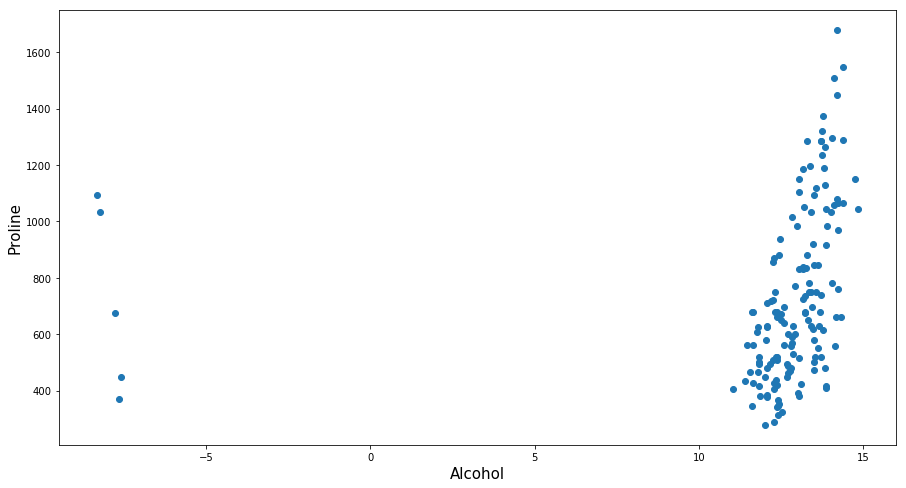

In [4]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.xlabel('Alcohol', fontsize=15)
plt.ylabel('Proline', fontsize=15)
plt.scatter(processed_data['Alcohol'], processed_data['Proline'])

In [5]:
#Removing outliers prability distribution
#mask = processed_data['Alcohol']>-5
#processed_data = processed_data[mask]

mean = processed_data['Alcohol'].mean()
std = processed_data['Alcohol'].std()
print(processed_data[~processed_data['Alcohol'].between(mean-4*std,mean+4*std)]['Alcohol'])
processed_data = processed_data[processed_data['Alcohol'].between(mean-4*std,mean+4*std)]

22    -8.226
42    -8.328
61    -7.584
118   -7.662
163   -7.776
Name: Alcohol, dtype: float64


### Decision Trees
Note: When predicting for the test data, you should train the model again using train + validation data.

**Question 4**: Train Decision Tree model on train data for criterions = {'gini', 'entropy'} and report the accuracies on the validation data. Select the best criterion and report the accuracy on the test data.

In [6]:
from sklearn.tree import DecisionTreeClassifier
X_train = pd.read_csv('data/wine_train_data.csv')
y_train = pd.read_csv('data/wine_train_labels.csv')
X_valid = pd.read_csv('data/wine_val_data.csv')
y_valid = pd.read_csv('data/wine_val_labels.csv')
X_test = pd.read_csv('data/wine_test_data.csv')
y_test = pd.read_csv('data/wine_test_labels.csv')

best_criterion = ''
best_leaf_size = 0
accuracy = 0
for criterion in ['gini', 'entropy']:
    for leaf_size in [2,5,10,20]:
        clf = DecisionTreeClassifier(criterion=criterion, min_samples_leaf=leaf_size)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
        print('Validation accuracy for criterion:{} min_samples_leaf:{} - {:.4f}'.format(criterion, leaf_size, accu))
        if accu > accuracy:
            best_criterion, best_leaf_size, accuracy = criterion, leaf_size, accu
print("Will choose to use criterion: {}, leaf_size: {}".format(best_criterion, best_leaf_size))

Validation accuracy for criterion:gini min_samples_leaf:2 - 0.9231
Validation accuracy for criterion:gini min_samples_leaf:5 - 0.9487
Validation accuracy for criterion:gini min_samples_leaf:10 - 0.8974
Validation accuracy for criterion:gini min_samples_leaf:20 - 0.8974
Validation accuracy for criterion:entropy min_samples_leaf:2 - 0.8718
Validation accuracy for criterion:entropy min_samples_leaf:5 - 0.9487
Validation accuracy for criterion:entropy min_samples_leaf:10 - 0.8974
Validation accuracy for criterion:entropy min_samples_leaf:20 - 0.8974
Will choose to use criterion: gini, leaf_size: 5


In [7]:
clf = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_leaf_size)
X_train_valid = pd.concat([X_train, X_valid])
y_train_valid = pd.concat([y_train, y_valid])
clf.fit(X_train_valid, y_train_valid)
y_pred = clf.predict(X_test)
test_accuracy = np.sum(y_pred == y_test['class'])*1.0/len(y_valid)
print("test accuracy is: {:.4f}".format(test_accuracy))


test accuracy is: 0.8205


**Question 5**: Use the criterion selected above to train Decision Tree model on train data for min samples split={2,5,10,20} and report the accuracies on the validation data. Select the best parameter and report the accuracy on the test
data.

In [19]:
best_split_size = 0
accuracy = 0

for split_size in [2,5,10,20]:
    clf = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_leaf_size, min_samples_split=split_size)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
    print('Validation accuracy for min_samples_split:{} - {:.4f}'.format(split_size, accu))
    if accu > accuracy:
        best_split_size, accuracy = split_size, accu
print("Will choose to use min_sample_split: {}".format(best_split_size))
clf = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_leaf_size, min_samples_split=best_split_size)
clf.fit(X_train_valid, y_train_valid)
y_pred = clf.predict(X_test)
test_accuracy = np.sum(y_pred == y_test['class'])*1.0/len(y_valid)
print("test accuracy is: {:.4f}".format(test_accuracy))

Validation accuracy for min_samples_split:2 - 0.9487
Validation accuracy for min_samples_split:5 - 0.9487
Validation accuracy for min_samples_split:10 - 0.9487
Validation accuracy for min_samples_split:20 - 0.9487
Will choose to use min_sample_split: 2
test accuracy is: 0.8205


show the decision tree

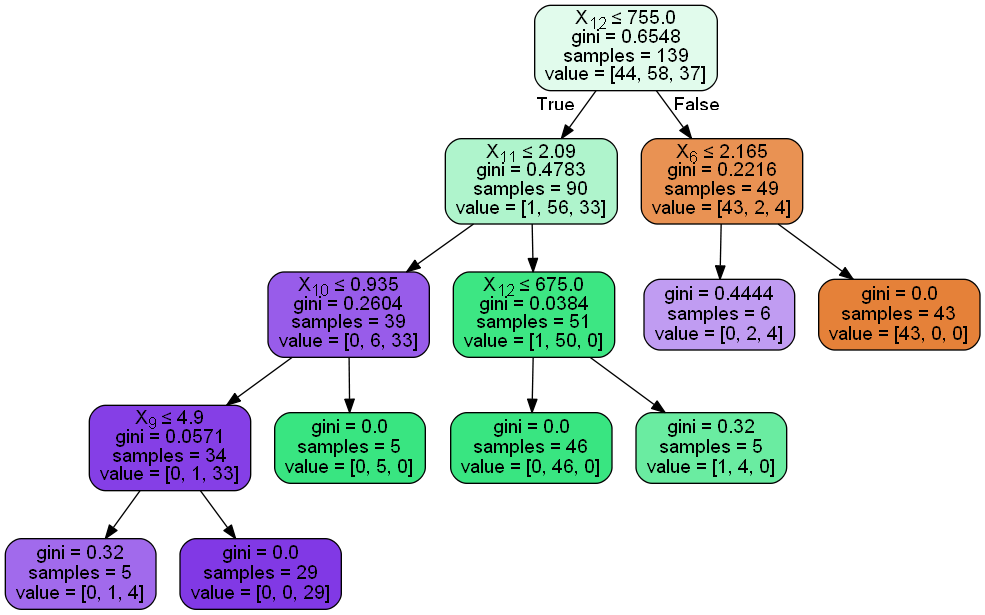

In [20]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image  
import pydotplus
dot_data = tree.export_graphviz(clf, out_file=None, 
                         #feature_names=iris.feature_names,  
                         #class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

**Question 6**: Use the parameters selected above (Q4 and Q5) to train Decision Tree model using the first 20, 40, 60, 80 and 100 samples from train data.
Keep the validation set unchanged during this analysis. Report and plot the accuracies on the validation data.

Validation accuracy with first 20 samples - 0.4615
Validation accuracy with first 40 samples - 0.8462
Validation accuracy with first 60 samples - 0.8462
Validation accuracy with first 80 samples - 0.8974
Validation accuracy with first 100 samples - 0.9487


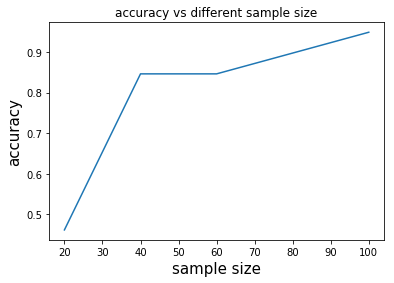

In [9]:
accuracy = []
sample_size = [20, 40, 60, 80, 100]
for n in sample_size:
    clf = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=best_leaf_size, min_samples_split=best_split_size)
    clf.fit(X_train[:n], y_train[:n])
    y_pred = clf.predict(X_valid)
    accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
    print('Validation accuracy with first {} samples - {:.4f}'.format(n, accu))
    accuracy.append(accu)
    
plt.title("accuracy vs different sample size")
plt.xlabel('sample size', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.plot(sample_size, accuracy)

### Nearest Neighbor
Normalize Data: Normalize features such that for each feature the mean is 0
and the standard deviation is 1 in the train+validation data. Use the normal-
izing factors calculated on train+validation data to modify the values in train,
validation and test data.

In [10]:
mean = X_train_valid.mean()
std = X_train_valid.std()
normalized_X_train = (X_train - mean) / std
normalized_X_valid = (X_valid - mean) / std
normalized_X_test = (X_test - mean) / std

**Question 7**: Train k-nn model on train + validation data and report accuracy on test data. Use Euclidean distance and k=3. (1 mark)

In [11]:
# Import the classifier
from sklearn.neighbors import KNeighborsClassifier
normalized_X_train_valid = pd.concat([normalized_X_train, normalized_X_valid])

clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
clf.fit(normalized_X_train_valid, y_train_valid['class']);
y_pred = clf.predict(normalized_X_test)
accuracy = np.sum(y_pred == y_test['class'])*1.0/len(y_test)
print("accuracy with Euclidean distance and k=3 is: {:.4f}".format(accuracy))

accuracy with Euclidean distance and k=3 is: 0.8718


**Question 8**: Train the model on train data for distance metrics defined by l1, linf, l2. Report the accuracies on the validation data. Select the best metric and report the accuracy on the test data for the selected metric. Use k=3.

In [12]:
best_metric = ''
accuracy = 0
for m in ['manhattan', 'euclidean', 'chebyshev']:
    clf = KNeighborsClassifier(n_neighbors=3, metric=m)
    clf.fit(normalized_X_train, y_train['class']);
    y_pred = clf.predict(normalized_X_valid)
    accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
    if accuracy < accu:
        best_metric, accuracy = m, accu
    print("Validation accuracy for metric {} is {:.4f}".format(m, accu))
    
print("Select best metric: {}".format(best_metric))
clf = KNeighborsClassifier(n_neighbors=3, metric=best_metric)
clf.fit(normalized_X_train_valid, y_train_valid['class']);
y_pred = clf.predict(normalized_X_test)
accuracy = np.sum(y_pred == y_test['class'])*1.0/len(y_test)
print("Test accuracy with metrics={} and k=3 is {:.4f}".format(best_metric, accuracy))

Validation accuracy for metric manhattan is 0.9487
Validation accuracy for metric euclidean is 0.9231
Validation accuracy for metric chebyshev is 0.9231
Select best metric: manhattan
Test accuracy with metrics=manhattan and k=3 is 0.9744


**Question 9**: Train the k-nn model on train data for k=1,3,5,7,9. Report and plot the accuracies on the validation data. Select the best 'k' value and report the accuracy on the test data for the selected 'k'. Use Euclidean distance.

Validation accuracy for k 1 is 0.9487
Validation accuracy for k 3 is 0.9231
Validation accuracy for k 5 is 0.9487
Validation accuracy for k 7 is 0.9744
Validation accuracy for k 9 is 0.9487
Select best k: 7


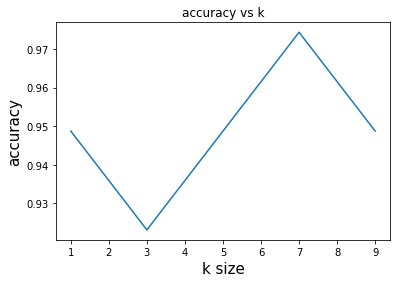

Test accuracy with Euclidean distance and k=7 is 0.9231


In [13]:
k_size = [1,3,5,7,9]
accuracy = []
for k in k_size:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(normalized_X_train, y_train['class']);
    y_pred = clf.predict(normalized_X_valid)
    accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
    accuracy.append(accu)
    print("Validation accuracy for k {} is {:.4f}".format(k, accu))

best_k = k_size[np.argmax(accuracy)]
print("Select best k: {}".format(best_k))
#plt.figure(figsize=(15,8))
plt.xlabel('k size', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.title('accuracy vs k')
plt.plot(k_size, accuracy)
plt.show()
clf = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
clf.fit(normalized_X_train_valid, y_train_valid['class']);
y_pred = clf.predict(normalized_X_test)
accuracy = np.sum(y_pred == y_test['class'])*1.0/len(y_test)
print("Test accuracy with Euclidean distance and k={} is {:.4f}".format(best_k, accuracy))

**Question 10**: Instead of using full train data, train the model using the ﬁrst 20, 40, 60, 80 and 100 data samples from train data. Keep the validation set unchanged during this analysis. Report and plot the accuracies on the validation data. Use Euclidean distance and k=3. Note: Don’t shuﬄe the data and use only the ’ﬁrst n samples’, otherwise your answers may diﬀer. 

Validation accuracy with first 20 samples - 0.9487
Validation accuracy with first 40 samples - 1.0000
Validation accuracy with first 60 samples - 1.0000
Validation accuracy with first 80 samples - 1.0000
Validation accuracy with first 100 samples - 0.9231


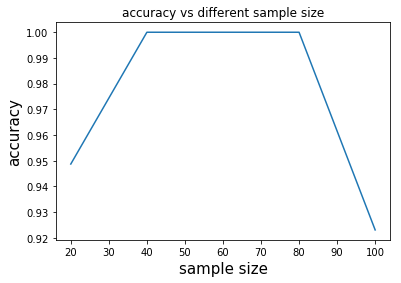

In [14]:
accuracy = []
sample_size = [20, 40, 60, 80, 100]
for n in sample_size:
    clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    clf.fit(normalized_X_train[:n], y_train[:n]['class'])
    y_pred = clf.predict(normalized_X_valid)
    accu = np.sum(y_pred == y_valid['class'])*1.0/len(y_valid)
    print('Validation accuracy with first {} samples - {:.4f}'.format(n, accu))
    accuracy.append(accu)
    
plt.title("accuracy vs different sample size")
plt.xlabel('sample size', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.plot(sample_size, accuracy)